# BDRAD Computer Vision Mini Project
#### Jessica Yeh, 2/20/2019

## Part 1: Image loading, resizing, reformatting

In [277]:
%matplotlib inline
import tensorflow as tf
import os
import pydicom
import numpy as np
import csv
import matplotlib.pyplot as plt
from pydicom.data import get_testdata_files
from skimage.transform import resize
from PIL import Image
from tensorflow import keras

In [283]:
def read_img(img_path, img_shape):
    """ Takes in a string image path and tuple image shape.
    Resizes .dcm or .png images to the specified shape and 
    returns the resized image in ndarray form."""
    
    img = []
    name, extension = os.path.splitext(img_path)
    if extension == '.png':
        img = Image.open(img_path)
        img = np.array(img) # converting to ndarray
    elif extension == '.dcm':
        ds = pydicom.dcmread(img_path)
        img = ds.pixel_array
        
    img = resize(img, img_shape)
    # uncomment below to not show resized image
#     plt.imshow(img, cmap=plt.cm.bone)
#     plt.show()
    return img
        

In [284]:
def get_density_ids(csv_name):
    """Takes in string name of csv.
    Returns a dict that maps id of patient/img to density"""
    
    density_ids = {}
    with open(csv_name, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            density = row["breast_density"]
            path = row["image file path"]
            patient_id = path.split('/')[0]
            density_ids[patient_id] = int(density)
    return density_ids

density_ids = get_density_ids('mass_case_description_train_set.csv')
density_ids_test = get_density_ids('mass_case_description_test_set.csv')


In [285]:
# Note: this part is hardcoded- it works for my data 
# based on how it is currently stored

def get_all_paths(start_path, header_name):
    """Gets all paths for .dcm files nested within the start_path 
    directory. header_name specifies the names of directories 
    that it looks within"""
    
    files = [f for f in os.listdir(start_path) if f.startswith(header_name)]
    img_paths = [] 

    for file in files: # Goes into dirs until reaching the .dcm file
        curr_path = os.path.join(start_path, file)
        while '.dcm' not in curr_path: 
            curr_dir = [f for f in os.listdir(curr_path) if '.DS' not in f][0]
            curr_path = os.path.join(curr_path, curr_dir)
        img_paths.append(curr_path)
    return img_paths

train_paths = get_all_paths('mammogram-train/CBIS-DDSM', 'Mass-Training')
test_paths = get_all_paths('mammogram-test/CBIS-DDSM', 'Mass-Test')    

In [286]:
def combine_data(img_paths, density_ids):
    """Takes in a list of paths and a dict of density ids.
    Returns 2 ndarrays, one of img ndarrays and another of integer 
    densities"""
    
    img_arr = np.array([np.empty([299,299])]) # init size of arr
    density_arr = np.array([])
    for path in img_paths:
        new_img = read_img(path, (299, 299))
        ds = pydicom.dcmread(path)
        patient_id = ds.PatientID # Get patientID from dcm
        density = density_ids[patient_id] # Use patientID to get density
        
        if density==1 or density==2:
            density = 0
        else:
            density = 1

        img_arr = np.concatenate((img_arr, np.array([new_img])))
        density_arr = np.append(density_arr, density)

    img_arr = img_arr[1:] # crop out the initialized empty arr
    return img_arr, density_arr
 
# Comment 2 lines below out if want to run on entire dataset
# This is for the sake of testing and efficient

# train_paths = train_paths[:10]
# test_paths = test_paths[:5]

# Getting final data
train_img, train_density = combine_data(train_paths, density_ids)
test_img, test_density = combine_data(test_paths, density_ids_test)


In [287]:
np.savez('data.npz', train_img=train_img, test_img=test_img, 
         train_density=train_density, test_density=test_density)

In [288]:
# Checking if the npz saved properly
npzfile = np.load('data.npz')
print(npzfile['train_img'].shape)
print(npzfile['train_density'].shape)
print(npzfile['test_img'].shape)
print(npzfile['test_density'].shape)

(350, 299, 299)
(350,)
(361, 299, 299)
(361,)


## My Resources
https://realpython.com/python-csv/

http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize

http://www.pythoninformer.com/python-libraries/numpy/numpy-and-images/

https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html#numpy.savez


# Part 2
6) Create a basic ResNet architecture to train on breast denseness (we will make this a 2D classification program with 2 classes). There are four breast densities: ABCD, but for this project, set Density A and B as "not dense". Density C and D as "dense" to make this a 2-class classification program. Please note that getting high  accuracy is not the goal at this point, but just writing a neural network algorithm that runs without error is fine.

7) Test the algorithm on the testing set and provide your predictions on the test set (it need not be good at this point).

8) Display 10 random mammogram images.

In [326]:
npzfile = np.load('data.npz')
print(npzfile['train_img'].shape)
print(npzfile['train_density'].shape)
print(npzfile['test_img'].shape)
print(npzfile['test_density'].shape)

train_img = npzfile['train_img']
train_density = npzfile['train_density']
test_img = npzfile['test_img']
test_density = npzfile['test_density']

(350, 299, 299)
(350,)
(361, 299, 299)
(361,)


In [327]:
train_labels = keras.utils.to_categorical(train_density, 2)
test_labels = keras.utils.to_categorical(test_density, 2)

In [328]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(299, 299)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [329]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [330]:
model.fit(train_img, train_labels, batch_size=32, epochs=5)

Epoch 1/5
350/350 [==============================] - 9s 26ms/step - loss: 5.6503 - acc: 0.5914
Epoch 2/5
350/350 [==============================] - 2s 6ms/step - loss: 6.0328 - acc: 0.6257
Epoch 3/5
350/350 [==============================] - 2s 5ms/step - loss: 6.0328 - acc: 0.6257
Epoch 4/5
350/350 [==============================] - 2s 5ms/step - loss: 6.0328 - acc: 0.6257
Epoch 5/5
350/350 [==============================] - 2s 5ms/step - loss: 6.0328 - acc: 0.6257


In [331]:
test_loss, test_acc = model.evaluate(test_img, test_labels)


print('Test accuracy:', test_acc)

predictions = model.predict(test_img)

361/361 [==============================] - 3s 9ms/step
Test accuracy: 0.581717452183985


# Part 3: Data Visualization
Create confusion matrix, ROC curve, gallery of errors (confident corrects, non-confident cases) 

In [332]:
import sklearn

print(predictions.astype(int))
# print(predictions[:,1])
flat_predictions = predictions[:,1].astype(int)

print(flat_predictions)

confusion_matrix = sklearn.metrics.confusion_matrix(flat_predictions, test_density)
# confusion_matrix = sklearn.metrics.confusion_matrix(predictions, test_labels)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]

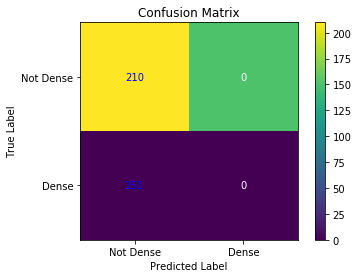

In [333]:
plt.imshow(confusion_matrix)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
locs, labels = plt.xticks()
plt.xticks([0,1], ["Not Dense", "Dense"]) 
plt.yticks([0,1], ["Not Dense", "Dense"]) 


plt.text(0, 0, confusion_matrix[0][0], ha="center", va="center", color="b")
plt.text(0, 1, confusion_matrix[0][1], ha="center", va="center", color="b")
plt.text(1, 0, confusion_matrix[1][0], ha="center", va="center", color="w")
plt.text(1, 1, confusion_matrix[1][1], ha="center", va="center", color="w")
        
plt.colorbar()
plt.show()


In [334]:
sklearn.metrics.roc_curve(test_label)

NameError: name 'test_label' is not defined